In [1]:
%pip install pandasql

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from scipy.special import boxcox1p

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")  # Ignoring Annoying Warnings    

from pandasql import sqldf
pysqldf = lambda q: sqldf (q, globals())

Note: you may need to restart the kernel to use updated packages.


In [2]:
features = pd.read_csv('features.csv')
train = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sampleSubmission.csv')

#### EXPLORATORY ANALYSIS AND DATA CLEANING :-

In [3]:
feat_sto = features.merge(stores, how='inner', on='Store')

In [4]:
feat_sto.head(5)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315


In [5]:
pd.DataFrame(feat_sto.dtypes, columns= ['Type'])

,Type
Store,int64
Date,object
Temperature,float64
Fuel_Price,float64
MarkDown1,float64
MarkDown2,float64
MarkDown3,float64
MarkDown4,float64
MarkDown5,float64
CPI,float64


In [6]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [7]:
pd.DataFrame({'Type_Train': train.dtypes, 'Type_Test': test.dtypes})

,Type_Train,Type_Test
Date,object,object
Dept,int64,int64
IsHoliday,bool,bool
Store,int64,int64
Weekly_Sales,float64,NaN


In [8]:
feat_sto.Date = pd.to_datetime(feat_sto.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

In [9]:
feat_sto['Week'] = feat_sto.Date.dt.isocalendar().week
feat_sto['Year'] = feat_sto.Date.dt.year

In [10]:
train_detail = train.merge(feat_sto,
                           how='inner',
                           on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                            'Dept',
                                                                            'Date']).reset_index(drop=True)

In [11]:
test_detail = test.merge(feat_sto,
                         how='inner',
                         on=['Store','Date','IsHoliday']).sort_values(by=['Store',
                                                                          'Dept',
                                                                          'Date']).reset_index(drop=True)

In [12]:
del features, train, stores, test

In [13]:
train_detail

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,5,2010
1,1,1,2010-02-12,46039.49,True,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,A,151315,6,2010
2,1,1,2010-02-19,41595.55,False,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,A,151315,7,2010
3,1,1,2010-02-26,19403.54,False,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,A,151315,8,2010
4,1,1,2010-03-05,21827.90,False,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,A,151315,9,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,False,64.88,3.997,4556.61,20.64,1.50,1601.01,3288.25,192.013558,8.684,B,118221,39,2012
421566,45,98,2012-10-05,628.10,False,64.89,3.985,5046.74,NaN,18.82,2253.43,2340.01,192.170412,8.667,B,118221,40,2012
421567,45,98,2012-10-12,1061.02,False,54.47,4.000,1956.28,NaN,7.89,599.32,3990.54,192.327265,8.667,B,118221,41,2012
421568,45,98,2012-10-19,760.01,False,56.47,3.969,2004.02,NaN,3.18,437.73,1537.49,192.330854,8.667,B,118221,42,2012


#### SEARCH FOR NULL VALUES FOR EACH COLUMN.

In [14]:
null_columns = (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False).index
null_data = pd.concat([
    train_detail.isnull().sum(axis = 0),
    (train_detail.isnull().sum(axis = 0)/len(train_detail)).sort_values(ascending=False),
    train_detail.loc[:, train_detail.columns.isin(list(null_columns))].dtypes], axis=1)
null_data = null_data.rename(columns={0: '# null',
                                      1: '% null',
                                      2: 'type'}).sort_values(ascending=False, by = '% null')
null_data = null_data[null_data["# null"]!=0]
null_data

,# null,% null,type
MarkDown2,310322,0.736110,float64
MarkDown4,286603,0.679847,float64
MarkDown3,284479,0.674808,float64
MarkDown1,270889,0.642572,float64
MarkDown5,270138,0.640790,float64


##### This Is Important, There Are Columns With More Than 60% Of Null Values. If The Correlations Of These Features With The Target 'WeekySales' Are~0, Then It Is Not A Good Idea To Use Them. Also, They Are Anonymized Fields, It Can Be Difficult To Know What They Mean.

### HOLIDAYS ANALYSIS:-

##### Here, We Will Analyze The Week Days That The Holidays Fall On Each Year. This Is Relevant To Know How Many Pre-Holiday Days Are Inside Each Week Marked As 'True' Inside 'IsHoliday' Filed.

##### If, For A Certain Week, There Are More Pre- Holiday Days In One Year Than Another, Then It Is Very Possible That The Year With More Pre-Holiday Days Will Have Greater Sales For The Same Week. So, The Model Will Not Take This Consideration And We Might Need To Adjust The Predicted Values At The End. 

##### Another Thing To Take Into Account Is That Holiday Weeks But With Few Or No Pre-Holiday Days Might Lower Sales Than The Week Before.

##### We Can Use SQL, Putting The Week Days For Each Holiday In Every Year. Doing Some Research, The Super Bowl, Labor Day And Thanksgiving Fall Same Day. In The Other Hand, Christmas Is Always On December 25th, So The Week Day Can Change.

In [15]:
pysqldf("""
SELECT
    T.*,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Super Bowl'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Labor Day'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thanksgiving'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 then 'Christmas'
    end as Holyday,
    case
        when ROW_NUMBER() OVER(partition by Year order by week) = 1 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 2 then 'Monday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 3 then 'Thursday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2010 then 'Saturday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2011 then 'Sunday'
        when ROW_NUMBER() OVER(partition by Year order by week) = 4 and Year = 2012 then 'Tuesday'
    end as Day
    from(
        SELECT DISTINCT
            Year,
            Week,
            case 
                when Date <= '2012-11-01' then 'Train Data' else 'Test Data' 
            end as Data_type
        FROM feat_sto
        WHERE IsHoliday = True) as T""")

,Year,Week,Data_type,Holyday,Day
0,2010,6,Train Data,Super Bowl,Sunday
1,2010,36,Train Data,Labor Day,Monday
2,2010,47,Train Data,Thanksgiving,Thursday
3,2010,52,Train Data,Christmas,Saturday
4,2011,6,Train Data,Super Bowl,Sunday
5,2011,36,Train Data,Labor Day,Monday
6,2011,47,Train Data,Thanksgiving,Thursday
7,2011,52,Train Data,Christmas,Sunday
8,2012,6,Train Data,Super Bowl,Sunday
9,2012,36,Train Data,Labor Day,Monday


In [16]:
pysqldf("""
SELECT 
    T.*,
    case 
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 1 THEN 'Super Bowl'
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 2 THEN 'Labor Day'
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 3 THEN 'Thanksgiving'
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 4 THEN 'Christmas'
    end as HOLIDAY,
    case
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 1 THEN 'Sunday'
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 2 THEN 'Monday'
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 3 THEN 'Thursday'
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 4 AND YEAR = 2010 THEN 'Saturday'
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 4 AND YEAR = 2011 THEN 'Sunday'
        WHEN ROW_NUMBER() OVER(PARTITION BY YEAR ORDER BY WEEK) = 4 AND YEAR = 2012 THEN 'Tuesday'
    end as DAY
    from(
         SELECT DISTINCT
              YEAR,
              WEEK,
              Case
                  WHEN DATE <='2012-11-01' THEN 'Train Data' ELSE 'Test Data'
              end as DATA_TYPE
    FROM feat_sto
        WHERE IsHoliday = True) as T""") 

,YEAR,WEEK,DATA_TYPE,HOLIDAY,DAY
0,2010,6,Train Data,Super Bowl,Sunday
1,2010,36,Train Data,Labor Day,Monday
2,2010,47,Train Data,Thanksgiving,Thursday
3,2010,52,Train Data,Christmas,Saturday
4,2011,6,Train Data,Super Bowl,Sunday
5,2011,36,Train Data,Labor Day,Monday
6,2011,47,Train Data,Thanksgiving,Thursday
7,2011,52,Train Data,Christmas,Sunday
8,2012,6,Train Data,Super Bowl,Sunday
9,2012,36,Train Data,Labor Day,Monday


##### Lets Take A Look At The Average Weekly Sales Per Year And Find Out If There Are Another Holiday Peak Sales That Were Not Considered By 'IsHoliday' Field.

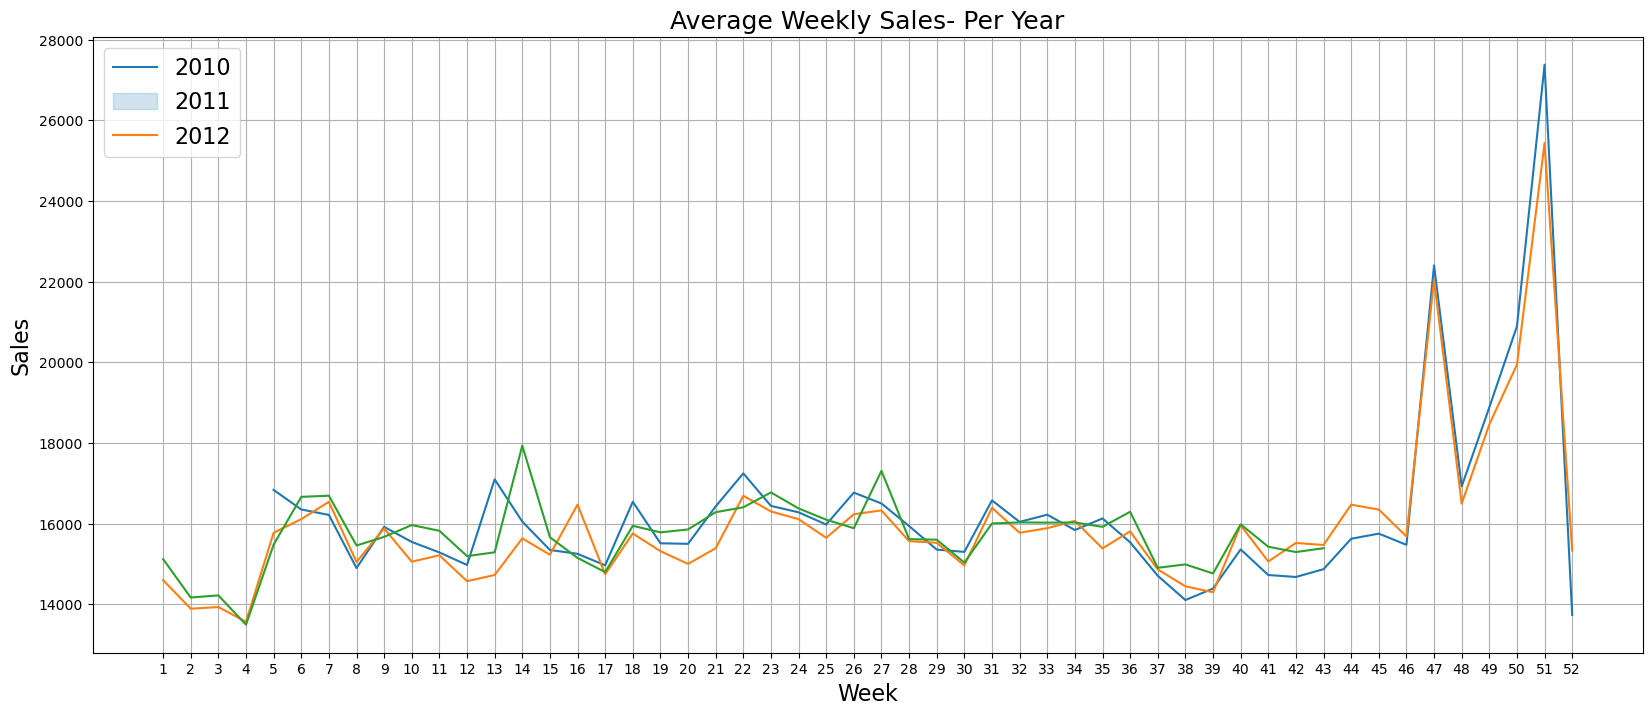

In [17]:
weekly_sales_2010 = train_detail[train_detail.Year==2010]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2011 = train_detail[train_detail.Year==2011]['Weekly_Sales'].groupby(train_detail['Week']).mean()
weekly_sales_2012 = train_detail[train_detail.Year==2012]['Weekly_Sales'].groupby(train_detail['Week']).mean()
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_2010.index, y=weekly_sales_2010.values)
sns.lineplot(x=weekly_sales_2011.index, y=weekly_sales_2011.values)
sns.lineplot(x=weekly_sales_2012.index, y=weekly_sales_2012.values)
plt.grid()
plt.xticks(np.arange(1, 53, step=1))
plt.legend(['2010', '2011', '2012'], loc='best', fontsize = 16)
plt.title('Average Weekly Sales- Per Year', fontsize =18)
plt.ylabel('Sales', fontsize = 16)
plt.xlabel('Week', fontsize = 16)
plt.show()

##### As We Can See, There Is One Important Holiday Not Include In 'IsHoliday'. It's The Easter Day. It Is Always In A Sunday, But Can Fall On Different Weeks. >* In 2010 Is In Week 13 >* In 2011, Week 16 >* Week 14 In 2012 >* And, Finally, Week 13 In 2013 For Test Set So, We Can Change To 'True' These Weeks In Each Year.

In [18]:
train_detail.loc[(train_detail.Year==2010) & (train_detail.Week==13), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2011) & (train_detail.Week==16), 'IsHoliday'] = True
train_detail.loc[(train_detail.Year==2012) & (train_detail.Week==14), 'IsHoliday'] = True
test_detail.loc[(train_detail.Year==2013) & (test_detail.Week==13), 'IsHoliday'] = True

#### The Same Chart, But Showing Also The Median Of The Sales And Not Divided By Year:-

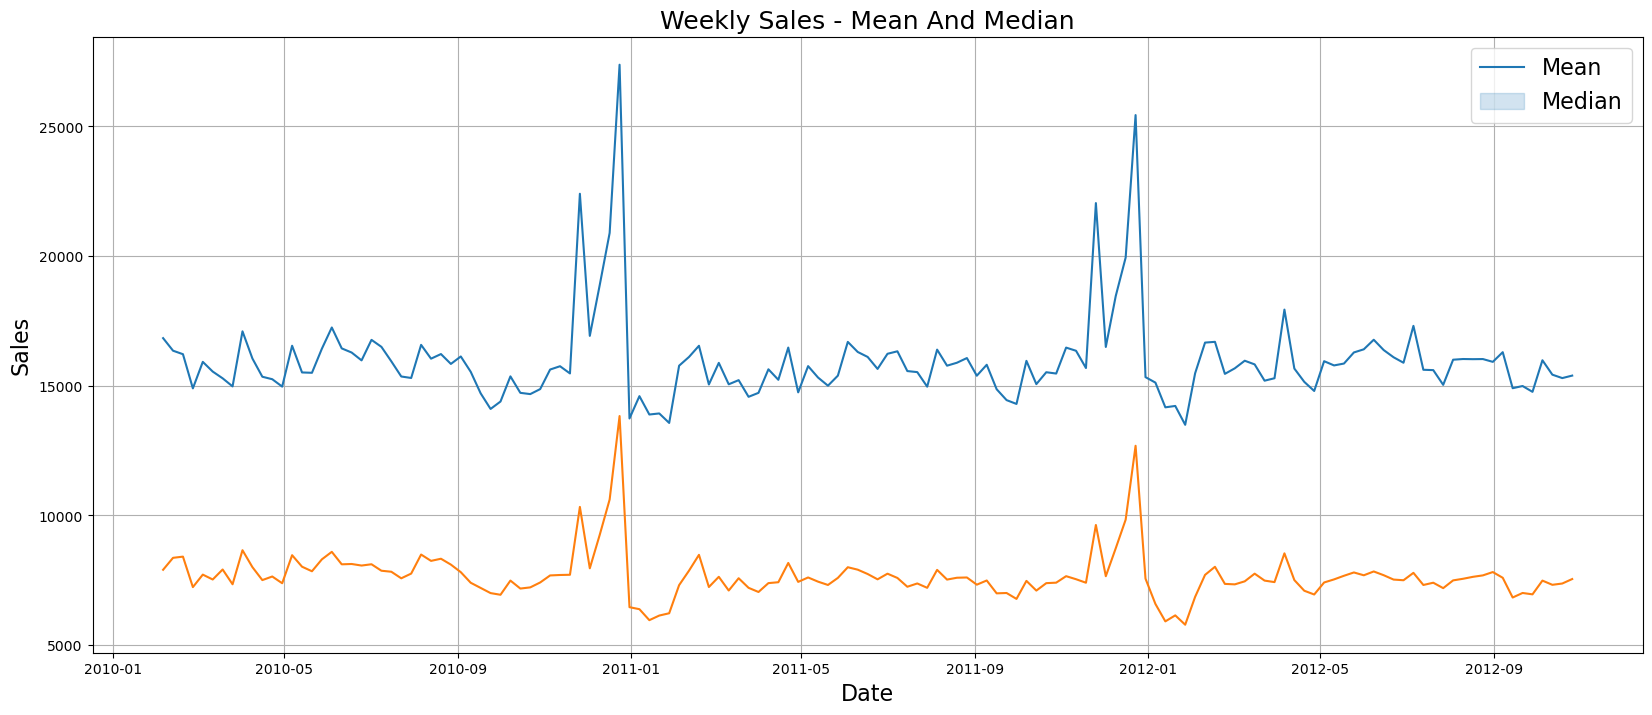

In [19]:
weekly_sales_mean =train_detail['Weekly_Sales'].groupby(train_detail['Date']).mean()
weekly_sales_median = train_detail['Weekly_Sales'].groupby(train_detail['Date']).median()
plt.figure(figsize=(20,8))
sns.lineplot(x=weekly_sales_mean.index, y=weekly_sales_mean.values)
sns.lineplot(x=weekly_sales_median.index, y=weekly_sales_median.values)
plt.grid()
plt.legend(['Mean', 'Median'],loc='best', fontsize=16)
plt.title('Weekly Sales - Mean And Median', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.show()

##### Just As An Observation, The Mean And The Median Are Very Different, Suggesting That Some Stores/Departments Mights Sell Much More Than Others. 

### AVERAGE SALES PER STORE AND DEPARTMENT:-

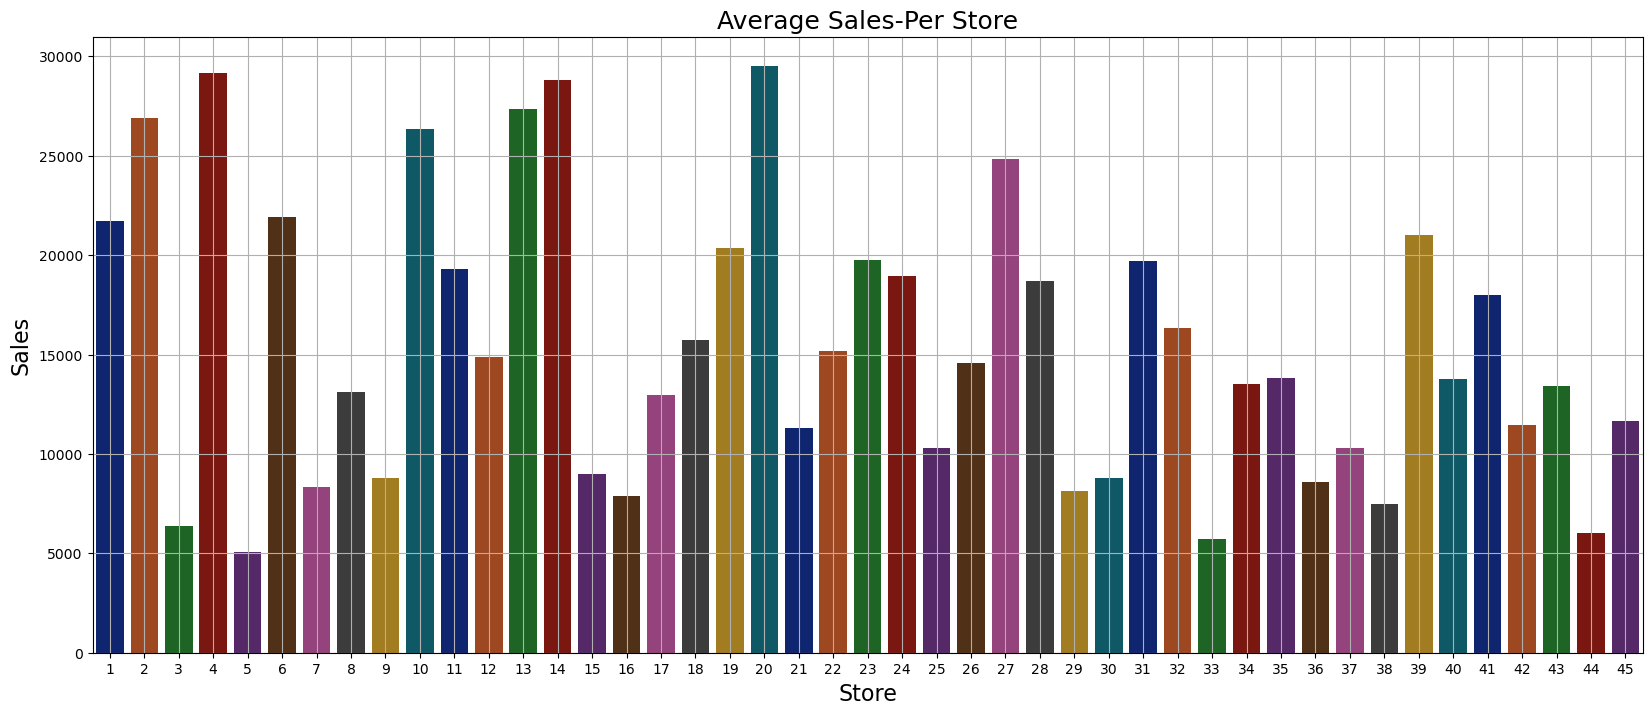

In [20]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Store']).mean()
plt.figure(figsize=(20,8))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales-Per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.show()

##### Yeah, There Are Sales Difference Between The Stores:-

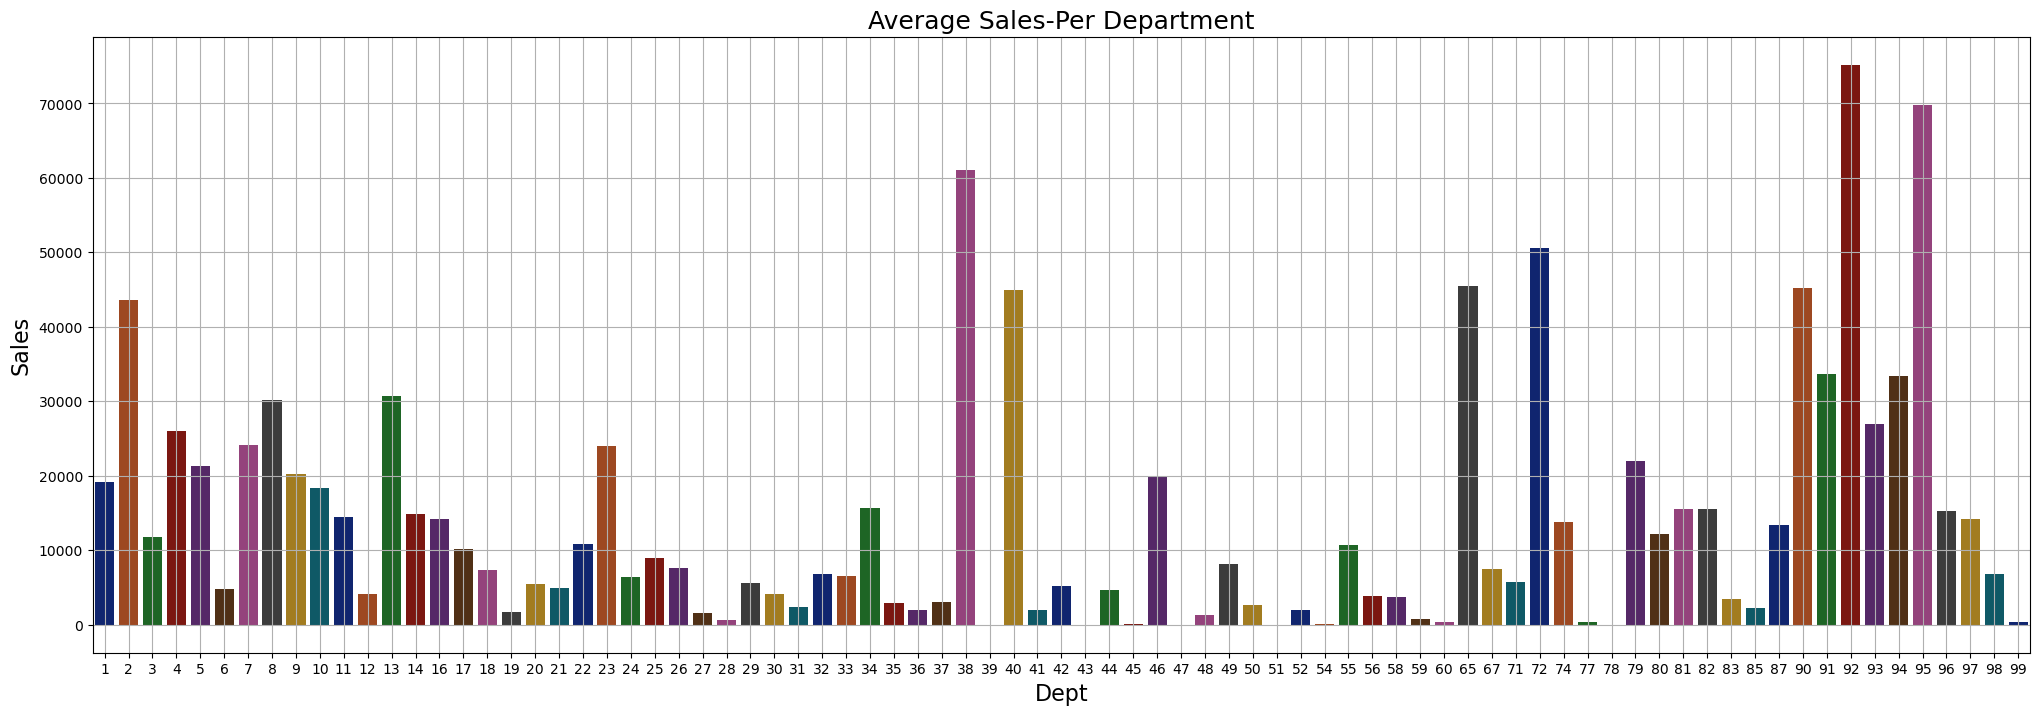

In [21]:
weekly_sales = train_detail['Weekly_Sales'].groupby(train_detail['Dept']).mean()
plt.figure(figsize=(25,8))
sns.barplot(x=weekly_sales.index, y=weekly_sales.values, palette='dark')
plt.grid()
plt.title('Average Sales-Per Department', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
plt.show()

##### And There Are Sales Difference Between The Department Too. Also Some Depts Are Not In The List, like Number '15', For Example.

### VARIABLES CORRELATIONS:-

##### Lets See The Correlation Between Variables, Using Pearson Correlation.
##### Correlation Metrics:>* 0: No Correlation At All >* 0-0.3: Weak Correlation >* 0.3-0.7: Moderate Correlation >* 0.7-1: Strong Correlation Positive Correlation Indicates That When One Variable Increase, The Other Also Does. Negative Is The Opposite.    

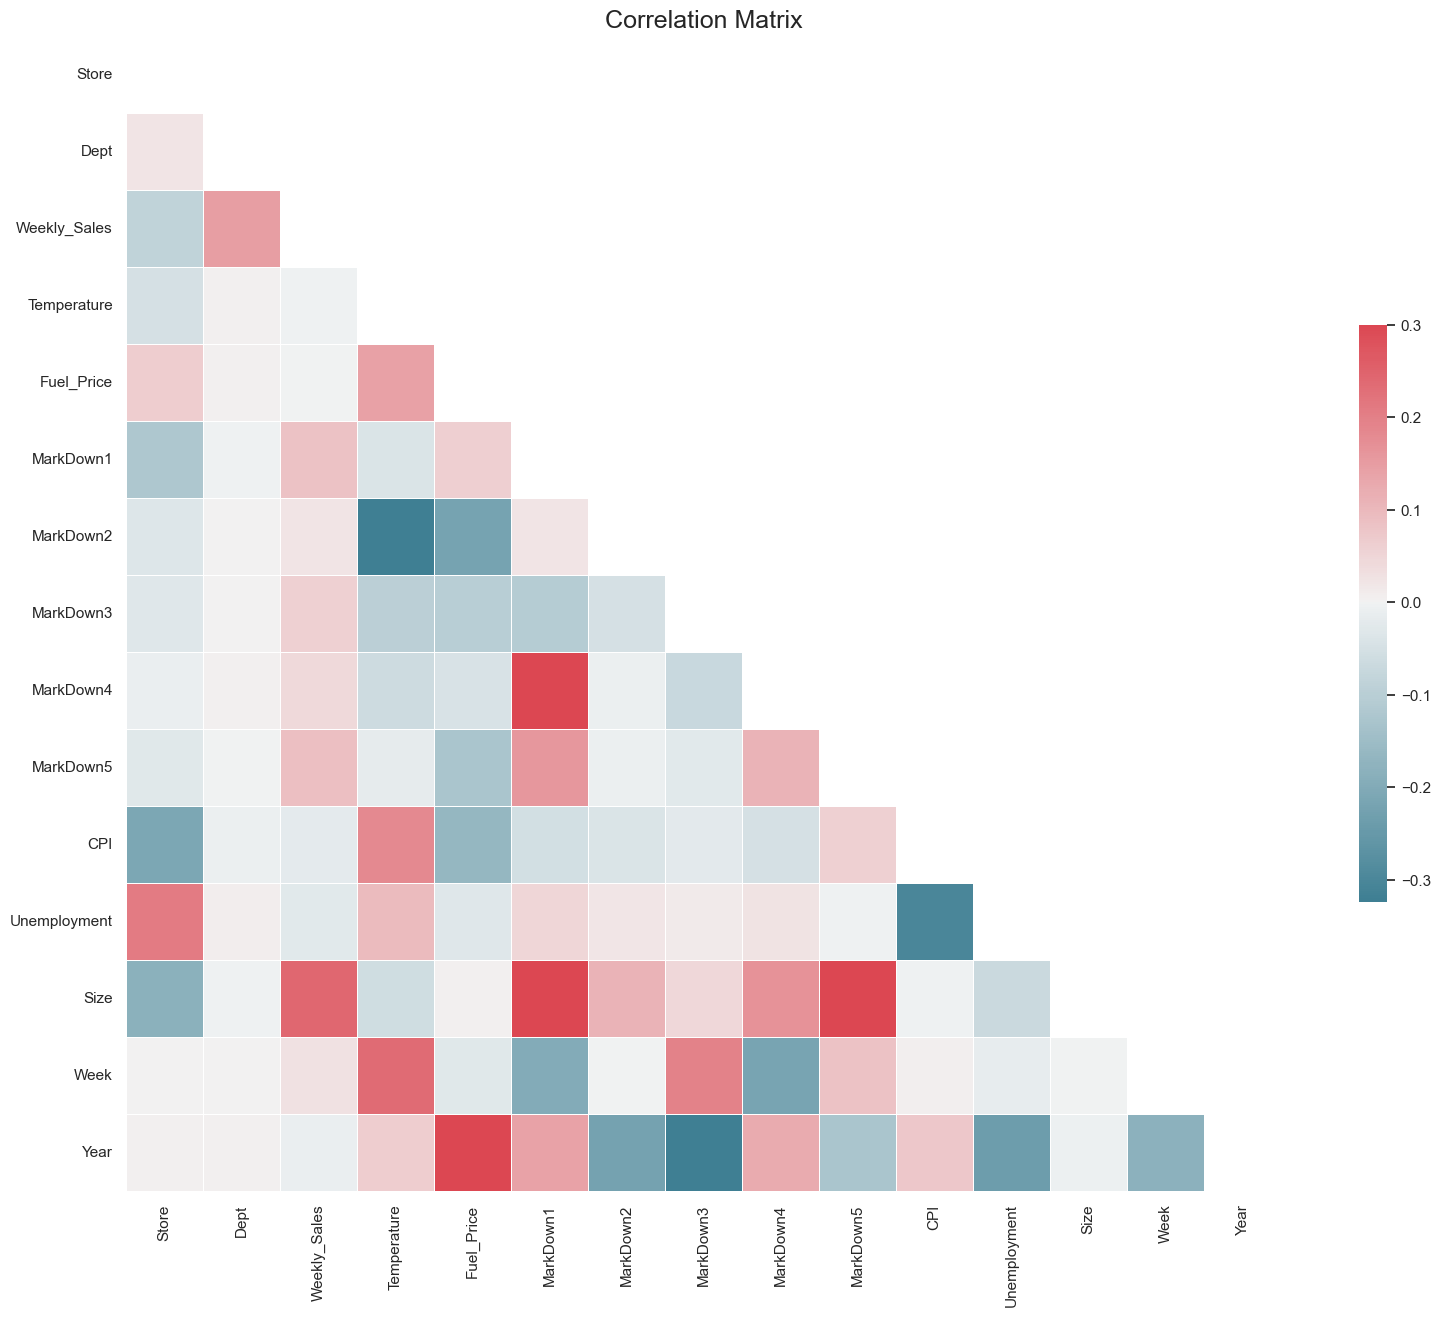

In [22]:
sns.set(style="white")

numeric_df = train_detail.select_dtypes(include=[np.number])

corr = numeric_df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

f, ax = plt.subplots(figsize=(20, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.title('Correlation Matrix', fontsize=18)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

##### 'MarkDown' 1 To 5 Are Not Strong Correlated To 'Weekly_Sales' And They Have A Lot Of Null Values, Then We Can Drop Them.

##### Also 'Fuel_Price' Is Strong Correlated To 'Year'. One Of Them Must Be Dropped Else They Would Carry Similar Information To The Model. 'Year' Will Not Be Dropped Because It Differentiate Same Weeks For 'Store' + 'Dept'.

##### Other Variable That Have Weak Correlation With 'Weekly_Sales' Can Be Analyzed To See If They Are Useful.

In [23]:
train_detail = train_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])
test_detail = test_detail.drop(columns=['Fuel_Price','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'])

### ANALYZING VARIABLES:-

##### First, Two Plot Functions That Will Help Us.

##### The Discrete Plot Is For Finite Numbers. We Will Use Boxplot, To See The Medians And Interquartile Ranges, And The Striplot, Which Is A Better Way Of Seeing The Distribution, Even More When Lots Of Outliers Are Present.

##### The Continious Plot, As The Name Says, Is For Continious Variables. We Will See The Distribution Of Probabilities And Use BoxCox To Understand If There Is Increase Of Correlation And Decrease Of Skewness For Each Variable. In Some Cases The Process Of Transforming A Variable Can Help, Depending On The Model.

In [24]:
 def make_discrete_plot(feature):
    fig = plt.figure(figsize=(20,8))
    gs = GridSpec(1,2)
    sns.boxplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,0]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    sns.stripplot(y=train_detail.Weekly_Sales, x=train_detail[feature], ax=fig.add_subplot(gs[0,1]))
    plt.ylabel('Sales', fontsize=16)
    plt.xlabel(feature, fontsize=16)
    fig.show()

In [25]:
def make_continuous_plot(feature):
    
    fig = plt.figure(figsize=(18,15))
    gs = GridSpec(2,2)
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

    plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.15)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.15), nan_policy='omit'),2)))
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=boxcox1p(train_detail[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

    plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(boxcox1p(train_detail[feature], 0.25)),2)) +
              ', Skew: ' + str(np.round(stats.skew(boxcox1p(train_detail[feature], 0.25), nan_policy='omit'),2)))
    
    j = sns.distplot(train_detail[feature], ax=fig.add_subplot(gs[1,1]), color = 'green')

    plt.title('Distribution\n')
    
    j = sns.scatterplot(y=train_detail['Weekly_Sales'], 
                        x=train_detail[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

    plt.title('Linear\n' + 'Corr: ' + str(np.round(train_detail['Weekly_Sales'].corr(train_detail[feature]),2)) + ', Skew: ' + 
               str(np.round(stats.skew(train_detail[feature], nan_policy='omit'),2)))
    
    fig.show()

#### Weekly_Sales X IsHoliday

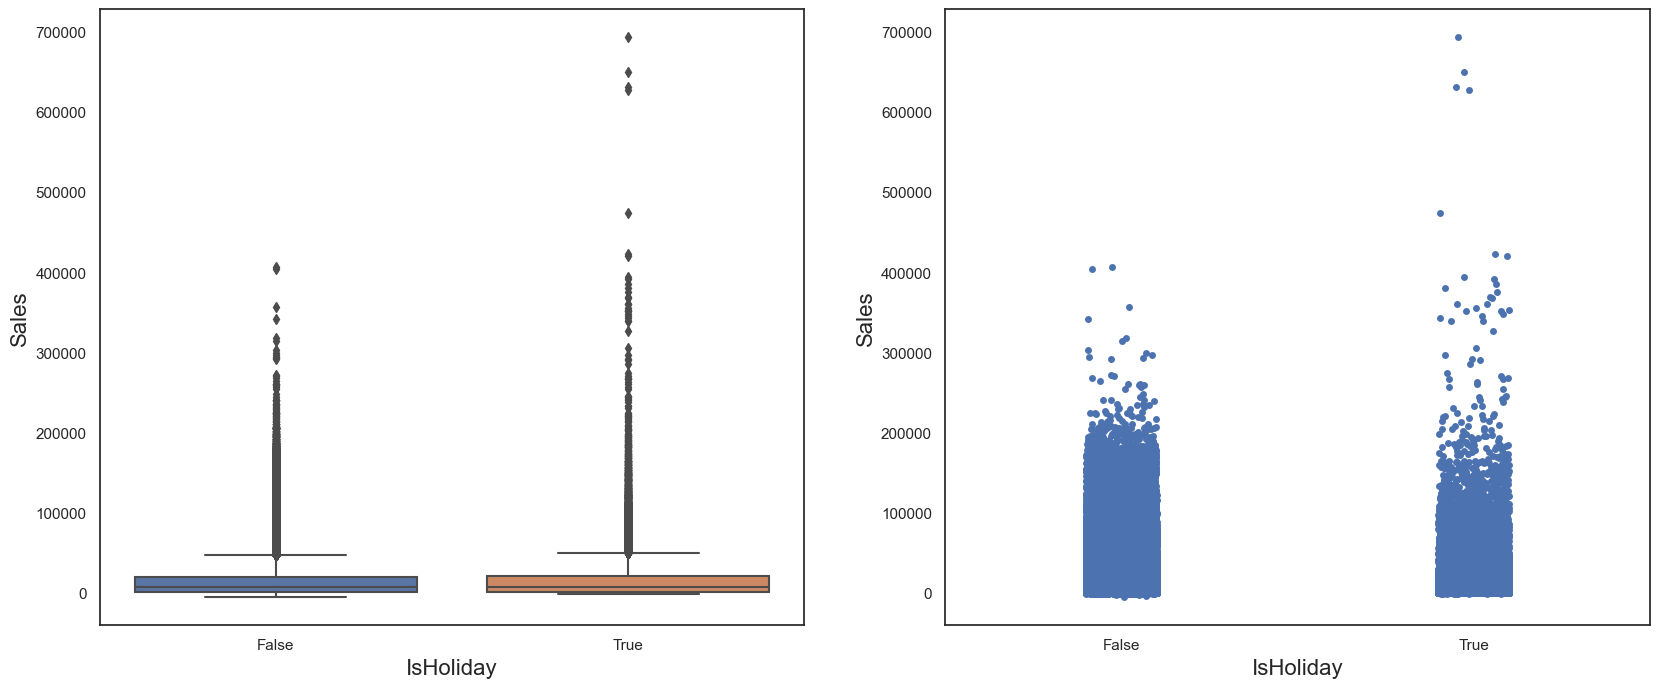

In [26]:
make_discrete_plot('IsHoliday')

##### This Field Is Going To Be Important To Differentiate Week Holidays. As We Can See, Week Holidays Have More High Sales Events Than Non-holiday Weeks.

#### Weekly_Sales x Type:-

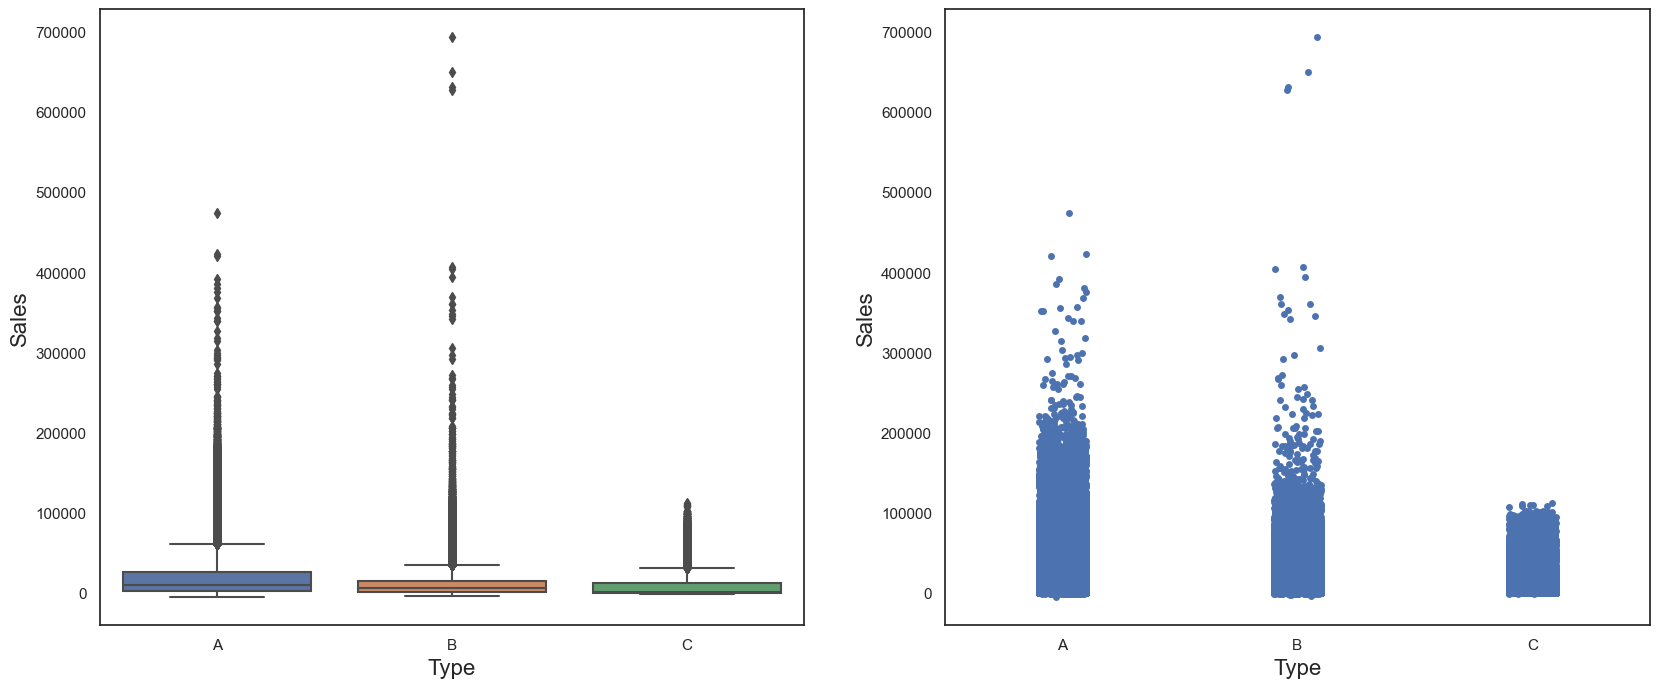

In [27]:
make_discrete_plot('Type')

##### We Don't Know What 'type' Is, But We Can Assume That A > B > C In Terms Of Sales Median. So, Let's Treat It As An Ordinal Variable And Replace Its Values.

##### Ordinal Variables Are Explained In The Figure Below.

In [28]:
train_detail.Type = train_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))
test_detail.Type = test_detail.Type.apply(lambda x: 3 if x == 'A' else(2 if x == 'B' else 1))

#### Weekly_Sales x Temperature:-

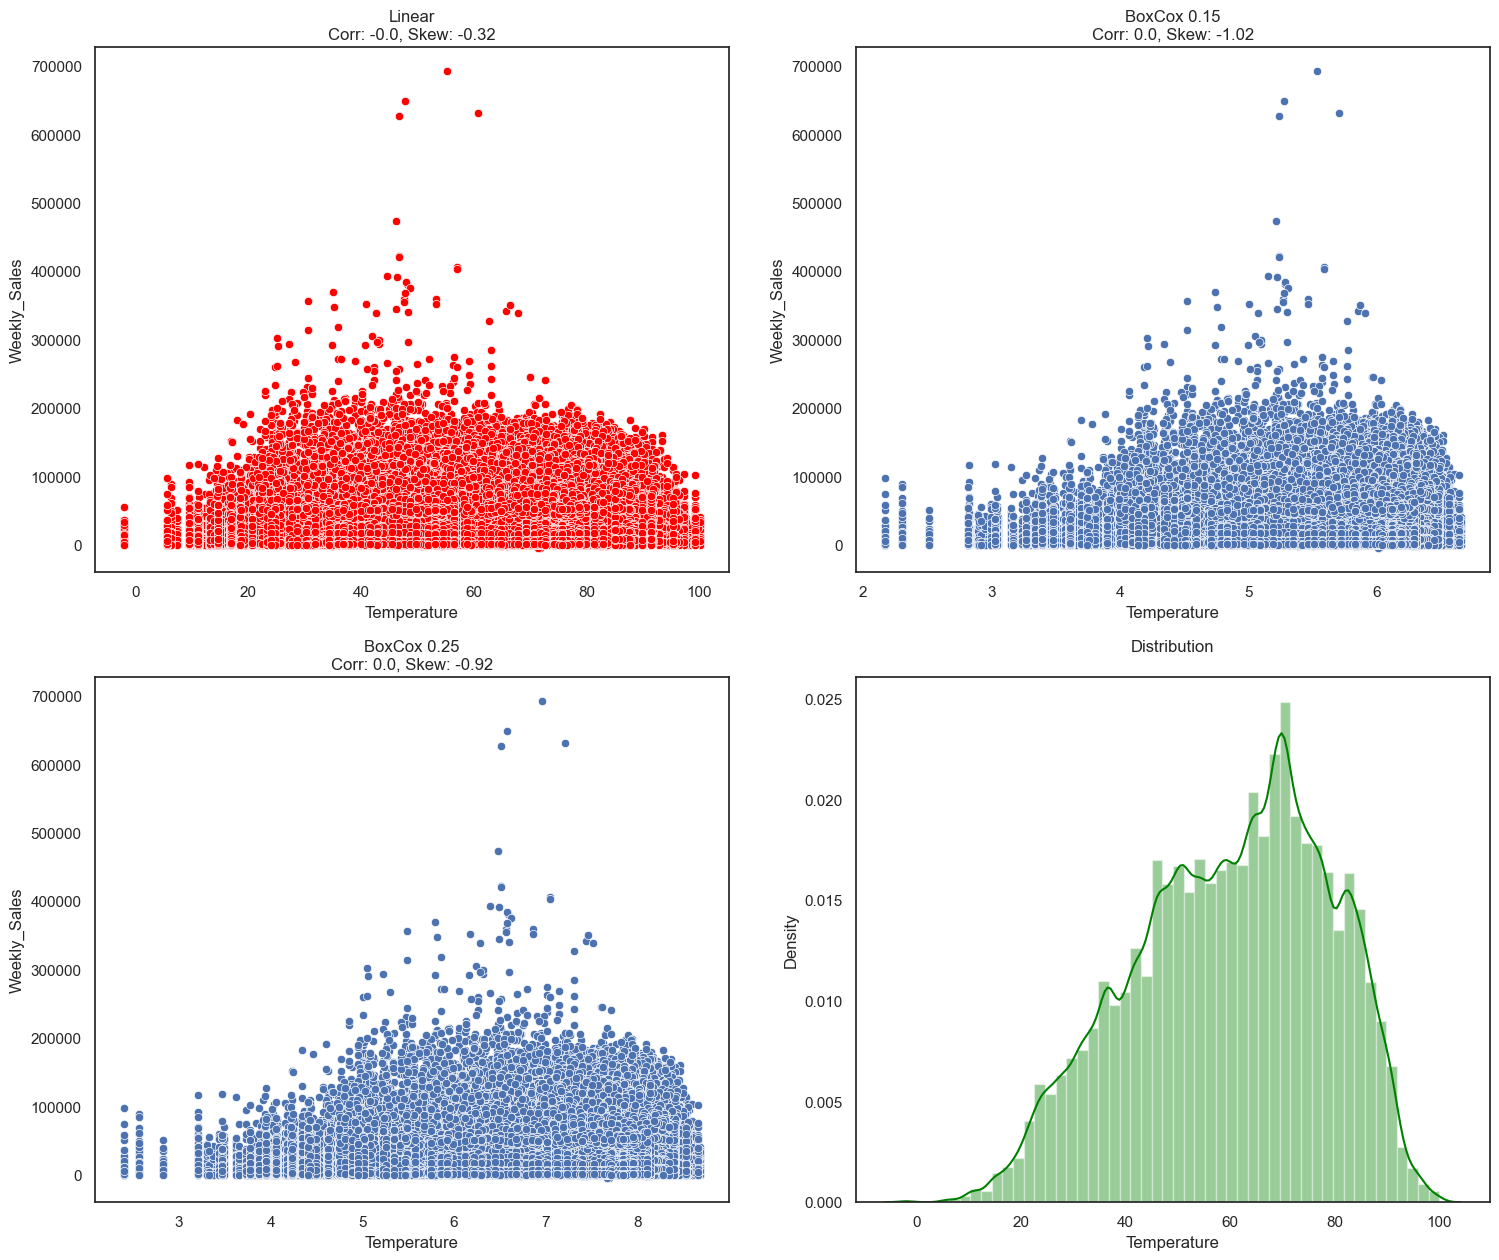

In [29]:
make_continuous_plot('Temperature')

##### Although Skewness Changes, Correlation Doesn't Seem To Change At All. We Can Decide To Drop It.

In [30]:
train_detail = train_detail.drop(columns=['Temperature'])
test_detail = test_detail.drop(columns=['Temperature'])

### Weekly_Sales x CPI

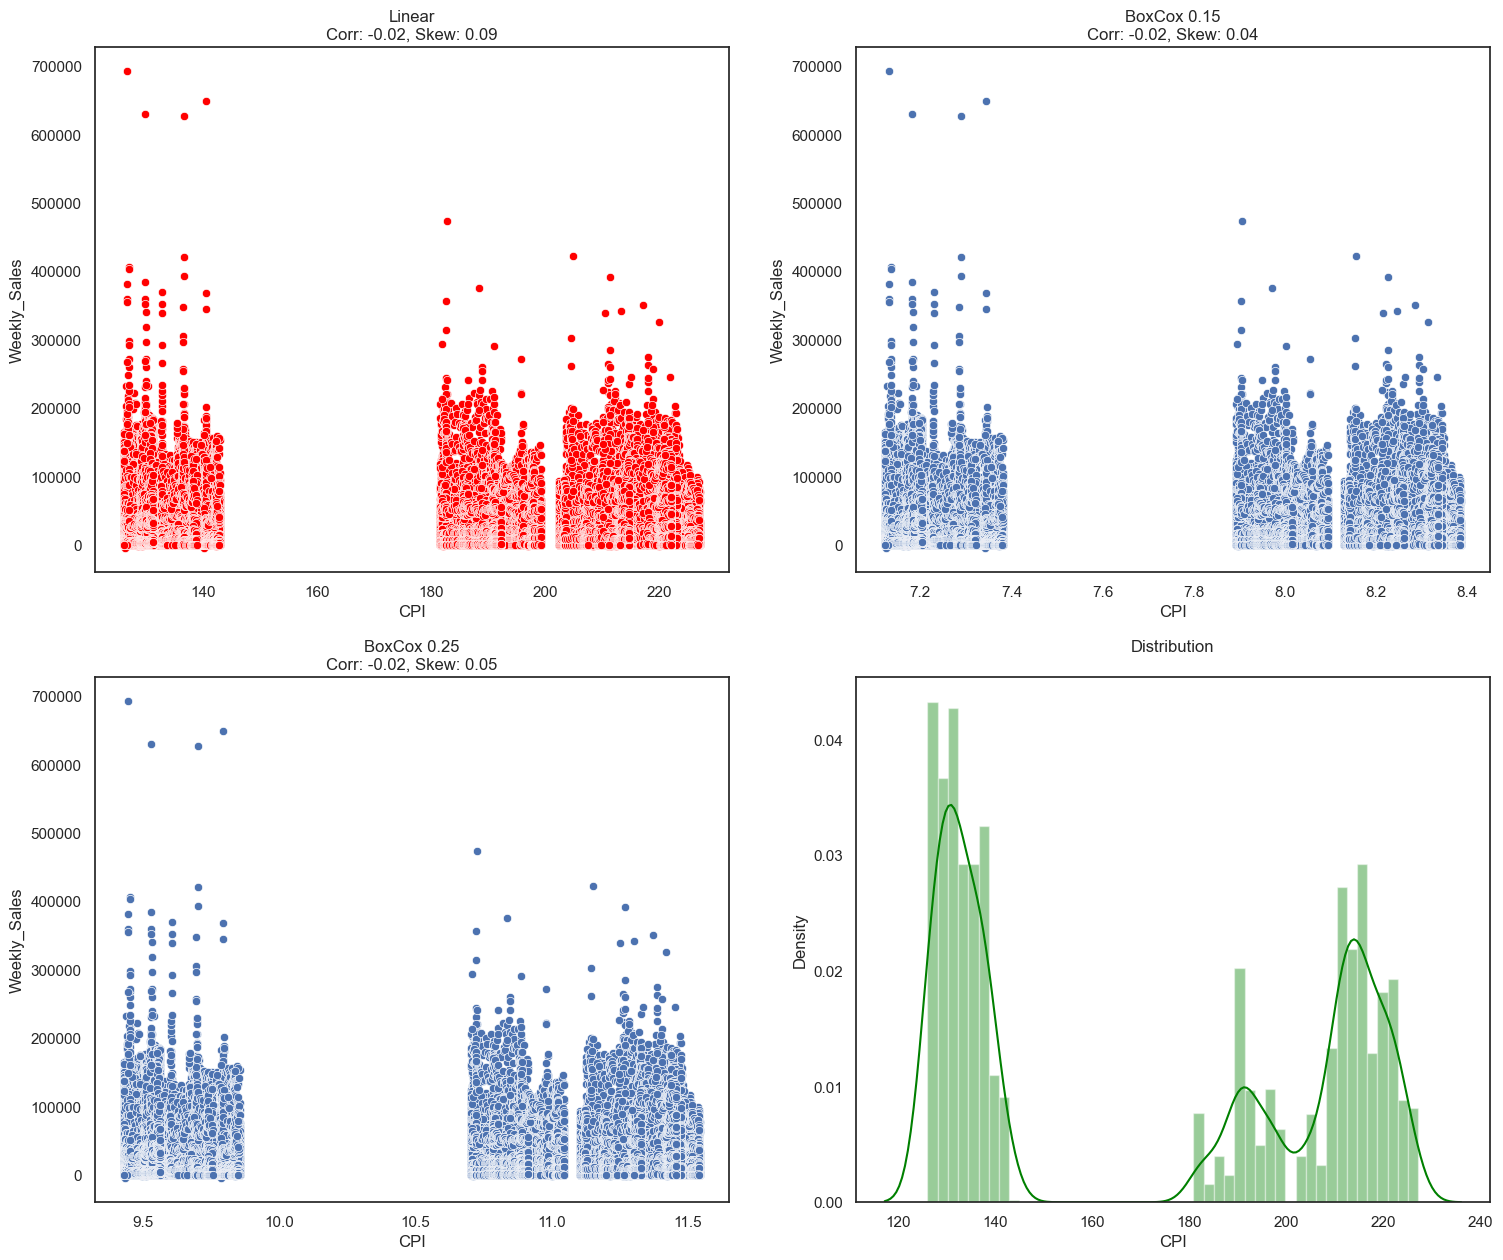

In [31]:
make_continuous_plot('CPI')

##### Same for 'CPI'.

In [32]:
train_detail = train_detail.drop(columns=['CPI'])
test_detail = test_detail.drop(columns=['CPI'])

#### Weekly_Sales x Unemployment:-

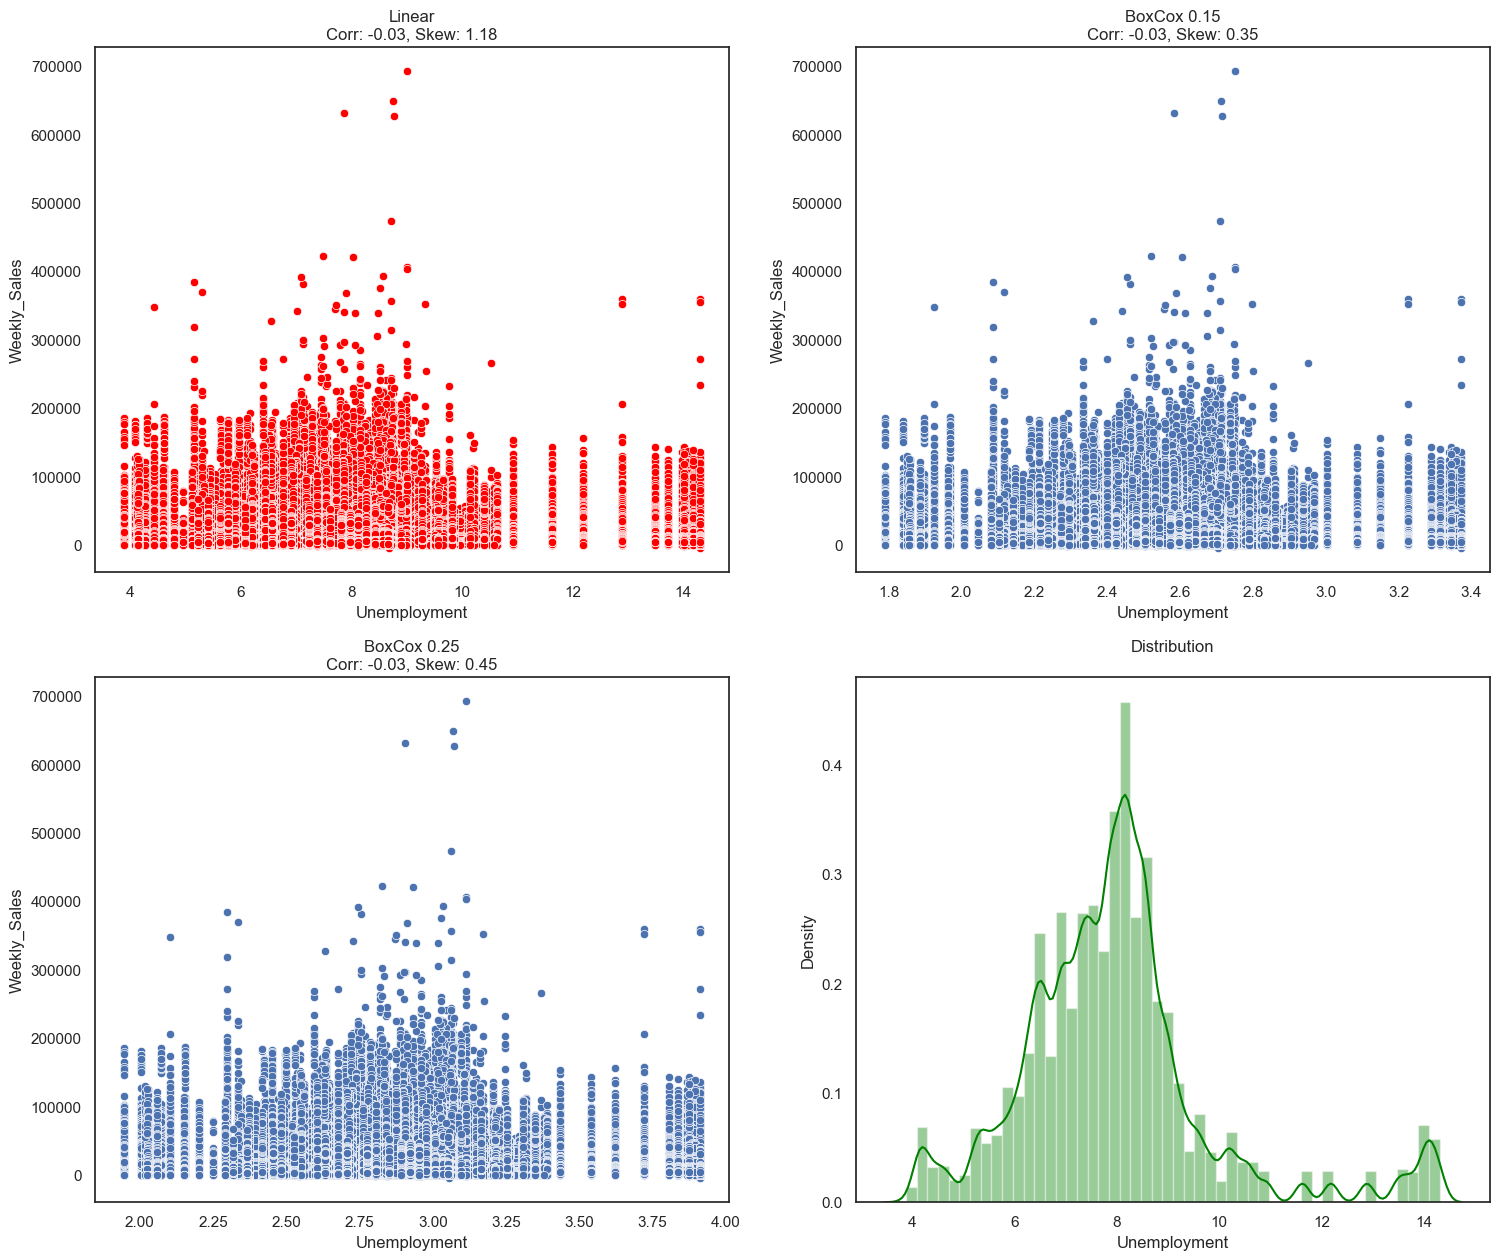

In [33]:
make_continuous_plot('Unemployment') 

#### Same for 'Unemployment' Rate:-

In [34]:
train_detail = train_detail.drop(columns=['Unemployment'])
test_detail = test_detail.drop(columns=['Unemployment'])

#### Weekly_Sales x Size:-

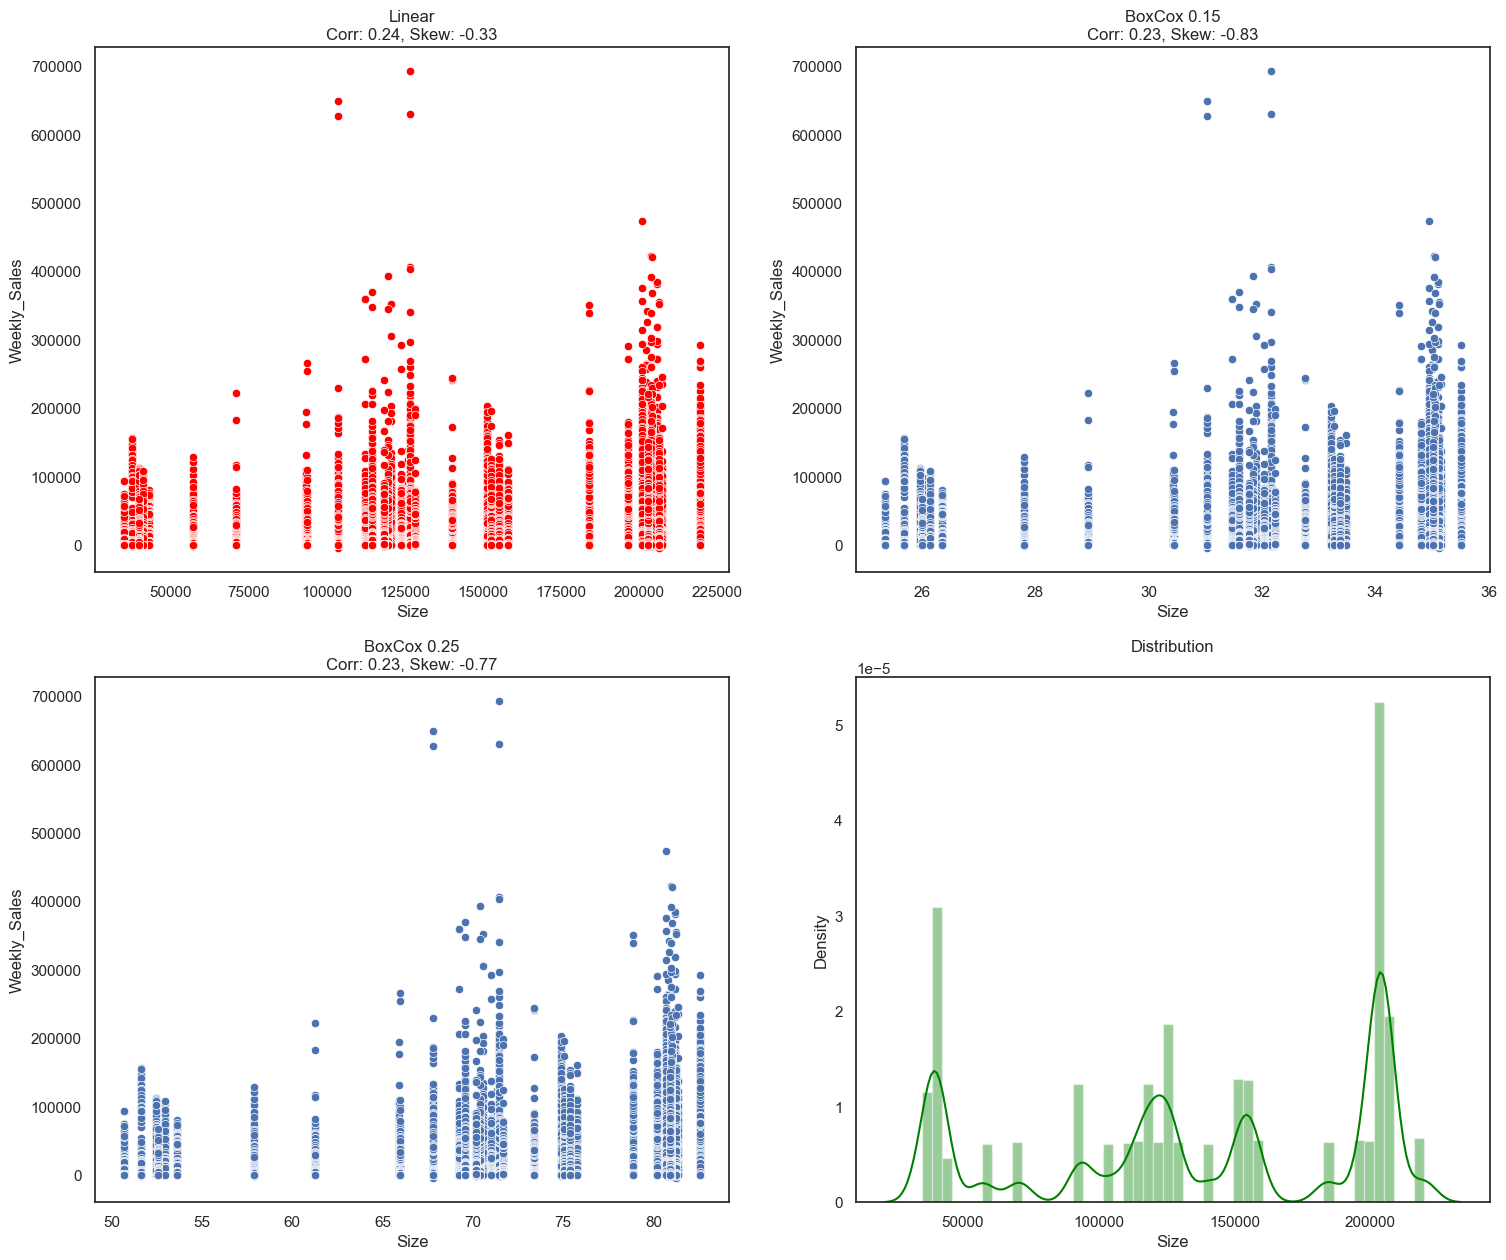

In [35]:
make_continuous_plot('Size')

##### And, Finally, We Will Continue With This Variable, Since It Has Moderate Correlation With 'WeeklySales'.

#### Machine Learning MACHINE LEARNING:-

#### MODEL FUNCTIONS:-

##### As We Can See In The Figure Below, The Evaluation Is Based On Weighted Mean Absolute Error (WMAE), With A Weight Of 5 For Holiday Weeks And 1 Otherwise.



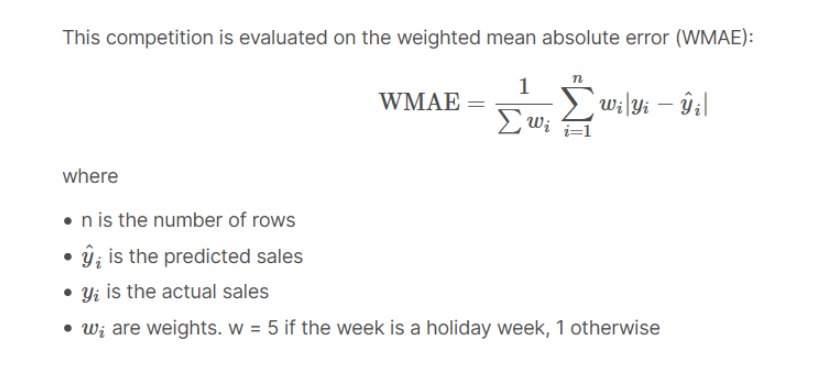

##### So, Turning The Formula Into A Function, Since We Cant Use GridSearchCV Or RandomSearchCV:-

In [36]:
def WMAE(dataset, real, predicted):
    weights = dataset.IsHoliday.apply(lambda x: 5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

##### The Model Chosen For This Project Is The Random Forest Regressor. It Is An Ensemble Method And Uses Multiples Decision Trees ('n_Estimators' 

##### Parameter Of The Model) To Determine Final Output, Which Is An Average Of The Outputs Of All Trees. 


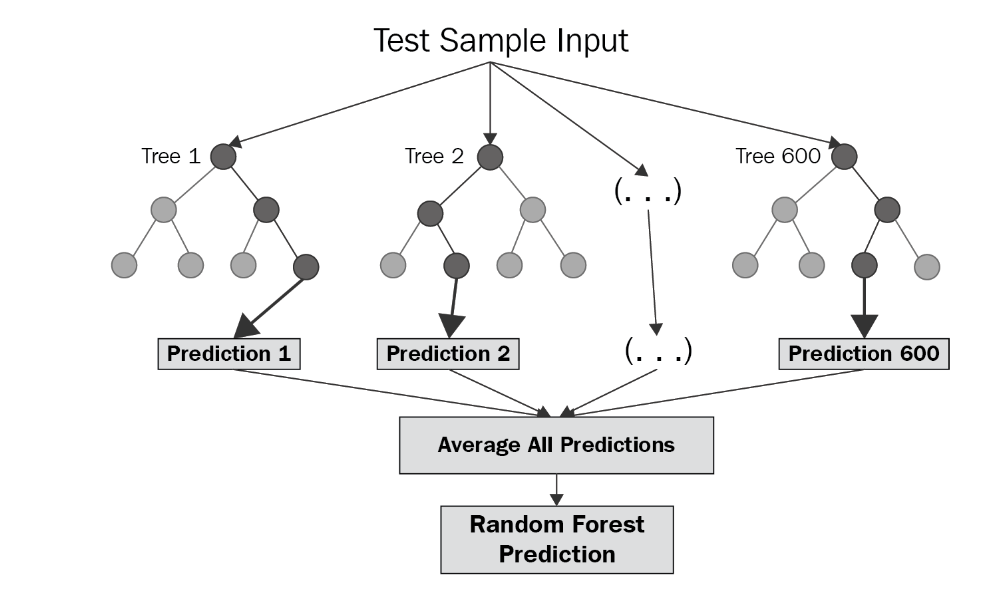

##### And The Structure Of A Decision Tree Is As Follows:-

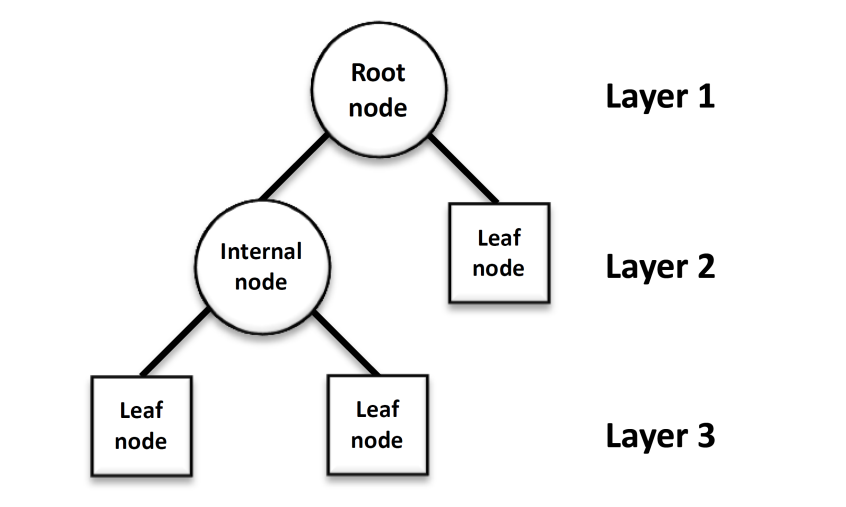


##### Reference: THE USE OF FACIAL MICRO-EXPRESSION STATE AND TREE-FOREST MODEL FOR PREDICTING CONCEPTUAL-CONFLICT BASED CONCEPTUAL CHANGE - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/Basic-structure-of-a-decision-tree-All-decision-trees-are- built-through-recursion_fig3_295860754 [accessed 2 Apr, 2020]


##### The Algorithm Chooses A Feature To Be The Root Node And Make A Split Of The Samples. The Function To Measure The Quality Of A Split 
##### We Can Choose And Pass As A Parameter. The Splitting Continues Until The Internal Node Has Less Samples Than 'min_samples_split' To Split And ##### Become A Leaf Node. And The 'min_samples_leaf' Tells The Minimum Number Of Samples To Be Considered As A Leaf Node. There Is Also An Important ##### Parameter Called 'max_features' And It Is The Maximum Number Of Features Considered When The Node Is Requiring The Best Split. The Number Of ##### Layers Is The 'max_depth' Parameter.


##### It Is Important To Tune These Parameters To Find The Best Predictor And To Minimize Overfitting
.

##### The Functions For Random Forest, Parameters Tuning And Cross Validation Are:-

In [37]:
def random_forest(n_estimators, max_depth):
    result = []
    for estimator in n_estimators:
        for depth in max_depth:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', n_estimators:', estimator, ', max_depth:', depth)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=estimator, max_depth=depth)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Max_Depth': depth, 'Estimators': estimator, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [38]:
def random_forest_II(n_estimators, max_depth, max_features):
    result = []
    for feature in max_features:
        wmaes_cv = []
        for i in range(1,5):
            print('k:', i, ', max_features:', feature)
            x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
            RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=feature)
            RF.fit(x_train, y_train)
            predicted = RF.predict(x_test)
            wmaes_cv.append(WMAE(x_test, y_test, predicted))
        print('WMAE:', np.mean(wmaes_cv))
        result.append({'Max_Feature': feature, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

In [39]:
def random_forest_III(n_estimators, max_depth, max_features, min_samples_split, min_samples_leaf):
    result = []
    for split in min_samples_split:
        for leaf in min_samples_leaf:
            wmaes_cv = []
            for i in range(1,5):
                print('k:', i, ', min_samples_split:', split, ', min_samples_leaf:', leaf)
                x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3)
                RF = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, max_features=max_features, 
                                           min_samples_leaf=leaf, min_samples_split=split)
                RF.fit(x_train, y_train)
                predicted = RF.predict(x_test)
                wmaes_cv.append(WMAE(x_test, y_test, predicted))
            print('WMAE:', np.mean(wmaes_cv))
            result.append({'Min_Samples_Leaf': leaf, 'Min_Samples_Split': split, 'WMAE': np.mean(wmaes_cv)})
    return pd.DataFrame(result)

### Training Model
##### Preparing Train Set.

In [40]:
X_train = train_detail[['Store','Dept','IsHoliday','Size','Week','Type','Year']]
Y_train = train_detail['Weekly_Sales']

##### Tuning 'n_estimators' And 'max_depth'.

##### Here, It Is Possible To Test A Lot Of Values. Those Are The Final Ones, After A Bit Of Testing.

In [ ]:
n_estimators = [56, 58, 60]
max_depth = [25, 27, 30]

random_forest(n_estimators, max_depth)

k: 1 , n_estimators: 56 , max_depth: 25
k: 2 , n_estimators: 56 , max_depth: 25


##### Tuning 'max_features'.

In [ ]:
max_features = [2, 3, 4, 5, 6, 7]

random_forest_II(n_estimators=58, max_depth=27, max_features=max_features)

##### Tuning 'min_samples_split' and 'min_samples_leaf'.

In [ ]:
min_samples_split = [2, 3, 4]
min_samples_leaf = [1, 2, 3]

random_forest_III(n_estimators=58, max_depth=27, max_features=6, 
                  min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

##### The Final Model:-

In [ ]:
RF = RandomForestRegressor(n_estimators=58, max_depth=27, max_features=6, min_samples_split=3, min_samples_leaf=1)
RF.fit(X_train, Y_train)

#### PREDICTIONS:-

In [ ]:
X_test = test_detail[['Store', 'Dept', 'IsHoliday', 'Size', 'Week', 'Type', 'Year']]
predict = RF.predict(X_test)

#### CHRISTMAS ADJUSTMENT:-
###### Let Us Make The Christmas Adjustment.

###### We Can Remember That Christmas Week Has 0 Pre-holiday Days In 2010, 1 In 2011 And 3 In 2012. So, It's A Difference Of 3 Days From 2012 To 2010 And 2 Days From 2012 To 2011. A 2.5 Days Average, In A Week (7 Days). So, This Is The Value That We Are Going To Multiply To Week 51 And Add To Week 52 To Compensate What The Model Didn't Take Into Account.

###### But We Are Going To Use This Formula Just For 'stores'+'departments' That Have A Big Difference Between Week 51 And Week 52 Sales. Let's Say Week51 > 2 * Week52.

###### Let's Use Another Dataframe And Sql To Solve It Quickly.

In [ ]:
Final = X_test[['Store', 'Dept', 'Week']]
Final['Weekly_Sales'] = predict

In [ ]:
Final_adj = pysqldf("""
    SELECT
        Store,
        Dept,
        Week,
        Weekly_Sales,
        case 
            when Week = 52 and last_sales > 2*Weekly_Sales then Weekly_Sales+(2.5/7)*last_sales
            else Weekly_Sales 
        end as Weekly_Sales_Adjusted
    from(
        SELECT
            Store, 
            Dept, 
            Week, 
            Weekly_Sales,
            case 
                when Week = 52 then lag(Weekly_Sales) over(partition by Store, Dept) 
            end as last_sales
        from Final)""")

##### SUBMISSION:-

In [ ]:
sample_submission['Weekly_Sales'] = Final_adj['Weekly_Sales_Adjusted']
sample_submission.to_csv('submission.csv',index=False)